In [20]:
import numpy as np
import matplotlib.pyplot as plt

import pyomo.environ as pyo
from pyomo.environ import ConcreteModel, Var, ConstraintList, Objective, SolverFactory, value, RangeSet, Constraint, Param
from pyomo.dae import *

import jax
import jax.numpy as jnp

from scipy.interpolate import interp1d
from jax.experimental.ode import odeint

import sys
import os

collocation2_path = os.path.abspath(os.path.join('..', 'utils'))

# Add the directory to sys.path
if collocation2_path not in sys.path:
    sys.path.append(collocation2_path)

from collocation import compute_weights, lagrange_derivative
from interpolation import BarycentricInterpolation
from data_generation import generate_ode_data
from non_parametric_collocation import collocate_data

In [8]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.2
ode_type = "harmonic_oscillator"
params = {"omega_squared": 1}
start_time=0
end_time=10
spacing_type="chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy = np.array(jnp.squeeze(y_noisy))
t = np.array(jnp.squeeze(t))

#---------------------------COLLOCATION MATRIX--------------------------#
weights = compute_weights(t)
D = lagrange_derivative(t, weights)
D = np.array(D)

In [30]:
import pyomo.environ as pyo
from pyomo.environ import ConcreteModel, RangeSet, ConstraintList, Objective
import numpy as np

# Assuming y_noisy and D (collocation matrix) are defined elsewhere
# Assuming t (time points) is defined elsewhere

#---------------------------MODEL CREATION--------------------------#
model = ConcreteModel()
model.t_idx = RangeSet(0, len(y_noisy) - 1)

input_size = 1  # t only
hidden_size = 10  
output_size = 2  # du/dt and dv/dt

#--------------------WEIGHTS AND BIASES----------------------#
def initialize_weights(shape):
    return np.random.randn(*shape) * 0.1

def initialize_biases(size):
    return np.random.randn(size) * 0.1

model.W1 = pyo.Var(range(hidden_size), range(input_size), initialize=lambda m, i, j: initialize_weights((hidden_size, input_size))[i, j])
model.b1 = pyo.Var(range(hidden_size), initialize=lambda m, i: initialize_biases(hidden_size)[i])
model.W2 = pyo.Var(range(output_size), range(hidden_size), initialize=lambda m, i, j: initialize_weights((output_size, hidden_size))[i, j])
model.b2 = pyo.Var(range(output_size), initialize=lambda m, i: initialize_biases(output_size)[i])

#---------------------------NEURAL NETWORK DEFINITIONS---------------------------#
def nn_output(t, m):
    # hidden layer (tanh activation)
    hidden_layer = [sum(m.W1[i, j] * t for j in range(input_size)) + m.b1[i] for i in range(hidden_size)]
    hidden_layer_tanh = [pyo.tanh(z) for z in hidden_layer]
    
    # output layer
    output = [sum(m.W2[k, i] * hidden_layer_tanh[i] for i in range(hidden_size)) + m.b2[k] for k in range(output_size)]
    return output

#---------------------------ODE CONSTRAINTS USING COLLOCATION MATRIX--------------------------#
penalty_terms = []
penalty_lambda = 7500

# Define variables for the integrated u and v
model.u = pyo.Var(model.t_idx, domain=pyo.Reals)
model.v = pyo.Var(model.t_idx, domain=pyo.Reals)

# Initial conditions (assumed known)
model.u[0] = 0.0
model.v[0] = 1.0

# ODE constraints using collocation matrix
model.ode = ConstraintList()
for i in range(1, len(y_noisy)):
    nn_du_dt_i, nn_dv_dt_i = nn_output(t[i], model)
    nn_du_dt_im1, nn_dv_dt_im1 = nn_output(t[i-1], model)
    
    dt = t[i] - t[i-1]
    u_integrated = model.u[i-1] + 0.5 * dt * (nn_du_dt_i + nn_du_dt_im1)
    v_integrated = model.v[i-1] + 0.5 * dt * (nn_dv_dt_i + nn_dv_dt_im1)
    
    model.ode.add(model.u[i] == u_integrated)
    model.ode.add(model.v[i] == v_integrated)
    
    penalty_terms.append((model.u[i] - u_integrated)**2 + (model.v[i] - v_integrated)**2)

#---------------------------OBJECTIVE FUNCTION DEFINITION--------------------------#
def _objective(m):
    data_fit = sum((m.u[i] - y_noisy[i, 0])**2 + (m.v[i] - y_noisy[i, 1])**2 for i in m.t_idx)
    penalty = penalty_lambda * sum(penalty_terms)
    return penalty + data_fit

model.obj = Objective(rule=_objective, sense=pyo.minimize)

#---------------------------SOLVING THE MODEL--------------------------#
solver = pyo.SolverFactory('ipopt')

solver.options['max_iter'] = 500
solver.solve(model, tee=True)


Ipopt 3.14.16: max_iter=500


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:    13134
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    13980

Total number of variables............................:      442
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      398

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 398, 'Number of variables': 442, 'Sense': 'unknown'}], 'Solver': [{'Status': 'warning', 'Message': 'Ipopt 3.14.16\\x3a Maximum Number of Iterations Exceeded.', 'Termination condition': 'maxIterations', 'Id': 400, 'Error rc': 0, 'Time': 8.791453838348389}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [31]:
def extract_weights(model, input_size, hidden_size, output_size):
    weights = {}
    
    # Extract weights and biases for the first layer
    W1 = np.array([[pyo.value(model.W1[j, k]) for k in range(input_size)] for j in range(hidden_size)])
    b1 = np.array([pyo.value(model.b1[j]) for j in range(hidden_size)])
    weights['W1'] = W1
    weights['b1'] = b1
    
    # Extract weights and biases for the second layer
    W2 = np.array([[pyo.value(model.W2[j, k]) for k in range(hidden_size)] for j in range(output_size)])
    b2 = np.array([pyo.value(model.b2[j]) for j in range(output_size)])
    weights['W2'] = W2
    weights['b2'] = b2
    
    return weights

def predict(t, weights, act_func="tanh"):
    inputs = jnp.array([t])
    
    # First layer
    W1, b1 = weights['W1'], weights['b1']
    hidden_layer = jnp.dot(W1, inputs) + b1
    if act_func == "tanh":
        hidden_layer = jax.nn.tanh(hidden_layer)
    elif act_func == "sigmoid":
        hidden_layer = jax.nn.sigmoid(hidden_layer)
    elif act_func == "softplus":
        hidden_layer = jax.nn.softplus(hidden_layer)
    
    # Second layer
    W2, b2 = weights['W2'], weights['b2']
    output = jnp.dot(W2, hidden_layer) + b2
    
    return output

def derivatives(y, t, weights):
    u, v = y
    du_dt, dv_dt = predict(t, weights)
    return [du_dt, dv_dt]

# Initial conditions
u0 = 0.0
v0 = 1.0
y0 = [u0, v0]

# Extract weights from the model
weights = extract_weights(model, input_size, hidden_size, output_size)

# Integrate the ODE using odeint
solution = odeint(derivatives, y0, t, weights)

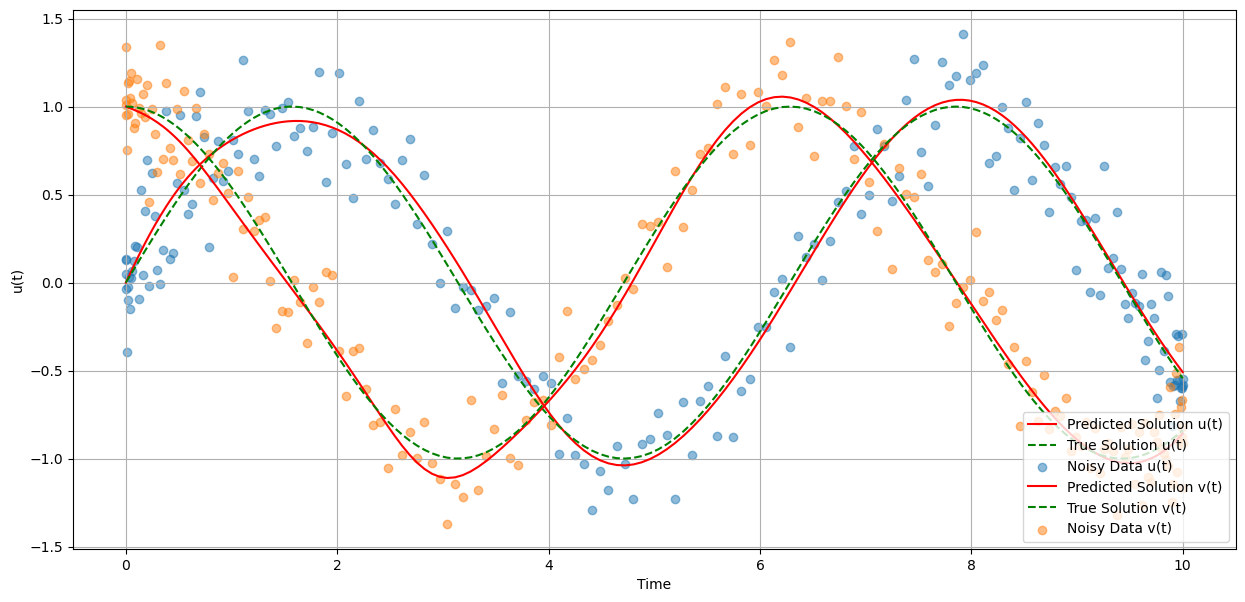

In [32]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
plt.plot(t, solution[0], 'r', label='Predicted Solution u(t)')
plt.plot(t, y.T[0], 'g--', label='True Solution u(t)')
plt.scatter(t, y_noisy.T[0], label='Noisy Data u(t)', alpha = 0.5)

plt.plot(t, solution[1], 'r', label='Predicted Solution v(t)')
plt.plot(t, y.T[1], 'g--', label='True Solution v(t)')
plt.scatter(t, y_noisy.T[1], label='Noisy Data v(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

In [35]:
t_new = np.linspace(t[0], 20, 200)

solution = odeint(derivatives, y0, t_new, weights)

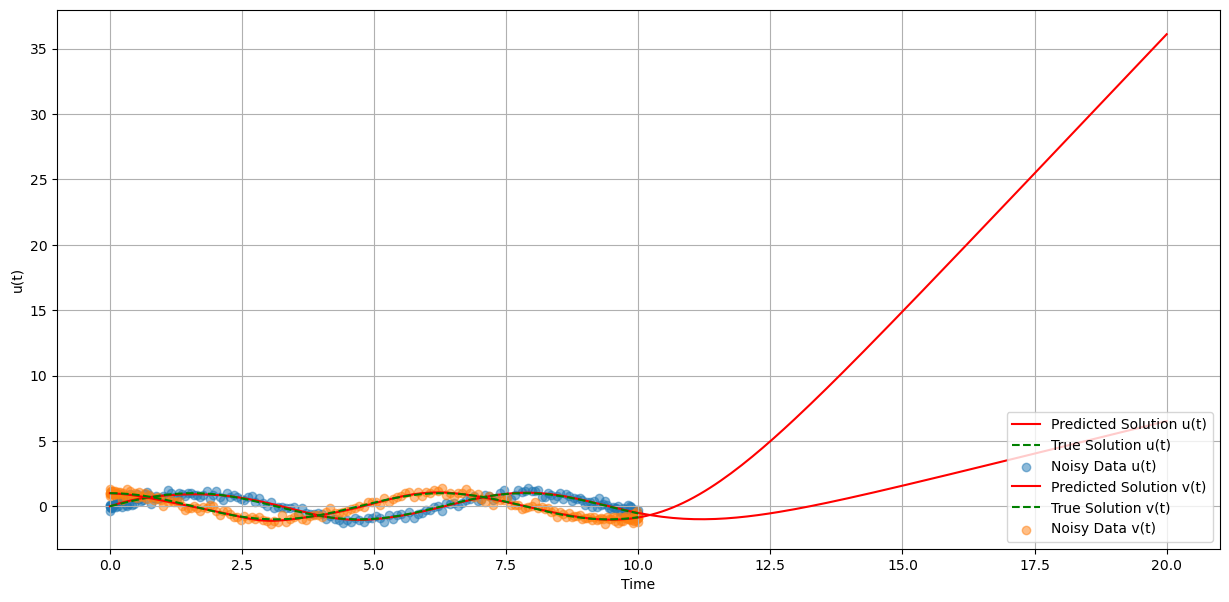

In [36]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
plt.plot(t_new, solution[0], 'r', label='Predicted Solution u(t)')
plt.plot(t, y.T[0], 'g--', label='True Solution u(t)')
plt.scatter(t, y_noisy.T[0], label='Noisy Data u(t)', alpha = 0.5)

plt.plot(t_new, solution[1], 'r', label='Predicted Solution v(t)')
plt.plot(t, y.T[1], 'g--', label='True Solution v(t)')
plt.scatter(t, y_noisy.T[1], label='Noisy Data v(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()